# Sentiment Analysis and modeling on Twitter data for

# Taylor Swift from Nov 2021 to Nov 2022,  
# in distributed data storage and processing environment 

In [1]:
!pip install spark-nlp==4.2.3
!pip install NLTK
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# import required packages 

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter('ignore')

from pyspark.sql.functions import isnan, when, count, col, lower, regexp_replace
from pyspark.sql.types import DateType

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.feature import RegexTokenizer
import re
from textblob import TextBlob

from pyspark.sql import functions as F
from pyspark.sql.types import StringType, StructType, StructField, FloatType

from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

from pyspark.ml.feature import StopWordsRemover, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import to_timestamp

import sys
import time

import nltk
from nltk.corpus import brown

In [3]:
#pyspark --conf "spark.mongodb.input.uri=mongodb://127.0.0.1/people.con?readPreference=primaryPreferred" 
  #--conf "spark.mongodb.output.uri=mongodb://127.0.0.1/people.con" 
    #--packages org.mongodb.spark:mongo-spark-connector_2.12:3.0.2

In [4]:
spark = SparkSession \
    .builder \
    .appName("sentiment_analysis") \
    .master('local')\
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/tweetsdb.tweetcoll") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/tweetsdb.tweetcoll") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

In [5]:
# Load data into hadoop using command prompt
# imported the collected csv file into mongodb by using the below command in command prompt

# mongoimport --db tweetsdb --collection tweetcoll --type csv --headerline --ignoreBlanks --file tstweet.csv

In [6]:
# Reading file from MongoDB into a spark dataframe
tweet = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
.option("spark.mongodb.input.uri","mongodb://127.0.0.1/tweetsdb.tweetcoll").load()

In [7]:
# checking metadata of data
tweet.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- id: long (nullable = true)
 |-- tweet: string (nullable = true)
 |-- username: string (nullable = true)



In [8]:
# Create Temp View
view_df = tweet.createOrReplaceTempView('data')
query = spark.sql("SELECT * from data")
query.show(5)

+----------+--------------------+--------------------+--------+-------------------+--------------------+--------------+
|Unnamed: 0|                 _id|                date|hashtags|                 id|               tweet|      username|
+----------+--------------------+--------------------+--------+-------------------+--------------------+--------------+
|         0|{638cbe37c3dea9f8...|2022-04-26 23:58:...|    null|1519103774664581121|@alannaheartstay ...| diamondssky13|
|         1|{638cbe37c3dea9f8...|2022-04-26 23:58:...|    null|1519103554853777408|Yo todavía no sup...|solamenteguada|
|         2|{638cbe37c3dea9f8...|2022-04-26 23:57:...|    null|1519103449576706048|@amanda_zcs @TheS...| julialazzari_|
|         3|{638cbe37c3dea9f8...|2022-04-26 23:57:...|    null|1519103408048848897|@taylorswift13 u ...| arlyxpimentel|
|         4|{638cbe37c3dea9f8...|2022-04-26 23:55:...|    null|1519103014656688135|@katievibesonly @...|  stillbejewel|
+----------+--------------------+-------

In [9]:
#dropping unwanted columns

df_d = tweet.drop("_id","Tweet ID","Unnamed: 0","Username","hashtags")

In [10]:
# checking shape of the data

print((df_d.count(), len(df_d.columns)))
type(df_d)

(291564, 3)


pyspark.sql.dataframe.DataFrame

In [11]:
# checking for missing values

df_d.select([count(when(col(c).isNull(), c)).alias(c) for c in df_d.columns]).show(5)

+----+---+-----+
|date| id|tweet|
+----+---+-----+
|   0|  0|    0|
+----+---+-----+



In [12]:
# checking dataframe

df_d.show(2)

+--------------------+-------------------+--------------------+
|                date|                 id|               tweet|
+--------------------+-------------------+--------------------+
|2022-04-26 23:58:...|1519103774664581121|@alannaheartstay ...|
|2022-04-26 23:58:...|1519103554853777408|Yo todavía no sup...|
+--------------------+-------------------+--------------------+
only showing top 2 rows



In [13]:
# check datatypes

df_d.printSchema()

root
 |-- date: string (nullable = true)
 |-- id: long (nullable = true)
 |-- tweet: string (nullable = true)



In [14]:
# Converting datatype of datecolumn as timestamp

spark_df1 = df_d.withColumn("TweetDate",to_timestamp("Date"))

In [15]:
spark_df1.printSchema()

root
 |-- date: string (nullable = true)
 |-- id: long (nullable = true)
 |-- tweet: string (nullable = true)
 |-- TweetDate: timestamp (nullable = true)



In [16]:
# Dropping the old column date from the dataframe

df_tweets = spark_df1.drop("Date")
df_tweets.show(2)

+-------------------+--------------------+-------------------+
|                 id|               tweet|          TweetDate|
+-------------------+--------------------+-------------------+
|1519103774664581121|@alannaheartstay ...|2022-04-27 00:58:58|
|1519103554853777408|Yo todavía no sup...|2022-04-27 00:58:05|
+-------------------+--------------------+-------------------+
only showing top 2 rows



In [17]:
# used pandas to read the tweets to get an idea for cleaning tweets

pd.options.display.max_columns = None
pd.options.display.max_rows = 250
pd.options.display.max_colwidth = 150
sns.set(color_codes = True)
df_tweets.limit(3).toPandas()

,id,tweet,TweetDate
0,1519103774664581121,"@alannaheartstay I hope it comes soon, but @taylorswift13 has a plan and will make it fun for all of us! 😊",2022-04-27 00:58:58
1,1519103554853777408,Yo todavía no supero Evermore de @taylorswift13,2022-04-27 00:58:05
2,1519103449576706048,@amanda_zcs @TheSwiftSociety @taylorswift13 @kit_connor QUE AMOR,2022-04-27 00:57:40


#### Text Preprocessing

In [18]:
# check to see if a row only contains whitespace
def check_blanks(data_str):
    is_blank = str(data_str.isspace())
    return is_blank

In [19]:
def check_lang(data_str):
    predict_lang = langid.classify(data_str)
    if predict_lang[1] >= .9: 
        language = predict_lang[0]
    else:
        language = 'NA'
    return language

In [20]:
# Remove features
def remove_features(data_str):
# compile regex 
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+) */?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation)) 
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)') 
    alpha_num_re = re.compile("^[a-z0-9_.]+$")

# convert to lowercase
    data_str = data_str.lower()
# remove hyperlinks
    data_str = url_re.sub(' ', data_str)
# remove @mentions
    data_str = mention_re.sub(' ', data_str)
# remove puncuation
    data_str = punc_re.sub(' ', data_str) 
# remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
# remove non a-z 0-9 characters and words shorter than 3 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 2: 
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 2: 
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
            list_pos += 1
        return cleaned_str

In [21]:
# Function to clean tweets(remove URL,users,punctuation,number,hashtag)

def cleanTweet(tweet: str) -> str:
    
    # remove URL
    tweet = re.sub(r'http\S+', '', str(tweet))
    tweet = re.sub(r'bit.ly/\S+', '', str(tweet))
    tweet = tweet.strip('[link]')

    # remove users
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))

    # remove punctuation
    my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@â'
    tweet = re.sub('[' + my_punctuation + ']+', ' ', str(tweet))

    # remove number
    tweet = re.sub('([0-9]+)', '', str(tweet))

    # remove hashtag
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))

    return tweet

In [22]:
# removes stop words
def remove_stops(data_str):
# expects a string 
    stops = set(stopwords.words("english")) 
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
# rebuild cleaned_str 
            if list_pos == 0: 
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word 
            list_pos += 1
        return cleaned_str

In [23]:
#tagging text
def tag_and_remove(data_str):
    cleaned_str = ' '
# noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
# adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
# verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] 
    nltk_tags = nn_tags + jj_tags + vb_tags
# break string into 'words'
    text = data_str.split()
# tag the text and keep only those with the right tags
    tagged_text = pos_tag(text)
    for tagged_word in tagged_text:
        if tagged_word[1] in nltk_tags:
            cleaned_str += tagged_word[0] + ' '
    return cleaned_str



In [24]:
# selecting dataframe
df_clean = df_tweets.select("Tweet","TweetDate")

# call function cleantweet
clean_tweets = F.udf(cleanTweet, StringType())

#create new column with cleaned tweets
cleaned_tweets = df_clean.withColumn('CleanedTweets', clean_tweets(col("Tweet")))

In [25]:
# viewing as a pandas dataframe for a better understanding of cleaned tweets

cleaned_tweets.limit(5).toPandas()

,Tweet,TweetDate,CleanedTweets
0,"@alannaheartstay I hope it comes soon, but @taylorswift13 has a plan and will make it fun for all of us! 😊",2022-04-27 00:58:58,I hope it comes soon but has a plan and will make it fun for all of us 😊
1,Yo todavía no supero Evermore de @taylorswift13,2022-04-27 00:58:05,Yo todavía no supero Evermore de
2,@amanda_zcs @TheSwiftSociety @taylorswift13 @kit_connor QUE AMOR,2022-04-27 00:57:40,QUE AMOR
3,@taylorswift13 u heard the people drop one 1989 vault track bc ik one of them HAS to be the summer bop https://t.co/Cu2bxcQdmP,2022-04-27 00:57:30,u heard the people drop one vault track bc ik one of them HAS to be the summer bop
4,@katievibesonly @taylorswift13 @taylornation13 Right??,2022-04-27 00:55:56,Right


In [26]:
# Clean text(To strip emojis and convert text into lowercase)

df_clean1 = cleaned_tweets.select('TweetDate', (lower(regexp_replace('CleanedTweets', "[^a-zA-Z\\s]", "")).alias('Text')))

In [27]:
# Recheck again

df_clean1.limit(2).toPandas()

,TweetDate,Text
0,2022-04-27 00:58:58,i hope it comes soon but has a plan and will make it fun for all of us
1,2022-04-27 00:58:05,yo todava no supero evermore de


In [28]:
#Import the lexicon 

import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
# Create a function to get the sentimentscore

# Create a function to get the Compound score
def getSentimentScore(tweetText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(tweetText)
    return float(vs['compound'])

def getSentiment(score):
    return 1 if score > 0 else 0


def getSentiment(compoundValue: int) -> str:
    if compoundValue < 0:
        return 'Negative'
    elif compoundValue == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [30]:
#check text column

df_text = df_clean1.select("Text").show(4)


+--------------------+
|                Text|
+--------------------+
| i hope it comes ...|
|yo todava no supe...|
|            que amor|
| u heard the peop...|
+--------------------+
only showing top 4 rows



In [31]:
# call function to get the sentiment score
sentimentscore = F.udf(getSentimentScore, FloatType())

# Call function to get the sentiment type
sentiment = F.udf(getSentiment, StringType())

#creating sentiment score column by passing the text coulmn
vader_sentiment_tweets = df_clean1.withColumn("sentimentscore", sentimentscore(col("Text")))

#creating sentiment type by passing the sentiment score column
sentiment_tweets_vd = vader_sentiment_tweets.withColumn("sentiment", sentiment(col("sentimentscore")))

In [32]:
sentiment_tweets_vd.show(5)

+-------------------+--------------------+--------------+---------+
|          TweetDate|                Text|sentimentscore|sentiment|
+-------------------+--------------------+--------------+---------+
|2022-04-27 00:58:58| i hope it comes ...|        0.7506| Positive|
|2022-04-27 00:58:05|yo todava no supe...|        -0.296| Negative|
|2022-04-27 00:57:40|            que amor|        0.6124| Positive|
|2022-04-27 00:57:30| u heard the peop...|       -0.2732| Negative|
|2022-04-27 00:55:56|              right |           0.0|  Neutral|
+-------------------+--------------------+--------------+---------+
only showing top 5 rows



In [33]:
# convert pandas dataframe to create visualisation and analyse the data

sentiment_vedar_pd = sentiment_tweets_vd.toPandas()

In [34]:
# check head of the pandas dataframe
sentiment_vedar_pd.head(5)

,TweetDate,Text,sentimentscore,sentiment
0,2022-04-27 00:58:58,i hope it comes soon but has a plan and will make it fun for all of us,0.7506,Positive
1,2022-04-27 00:58:05,yo todava no supero evermore de,-0.2960,Negative
2,2022-04-27 00:57:40,que amor,0.6124,Positive
3,2022-04-27 00:57:30,u heard the people drop one vault track bc ik one of them has to be the summer bop,-0.2732,Negative
4,2022-04-27 00:55:56,right,0.0000,Neutral


In [35]:
# writing to csv to get dataset for dashboard
sentiment_vedar_pd.to_csv("tweetprocess.csv")

<AxesSubplot: xlabel='sentiment', ylabel='count'>

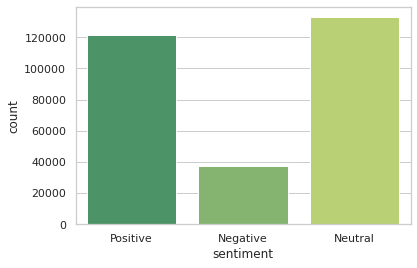

In [36]:
#Plot barchart to visualise the distributions of sentiment classes

sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=sentiment_vedar_pd, palette='summer')

In [37]:
# grouping by sentiments to get the counts

x = sentiment_tweets_vd.groupby("sentiment").count().toPandas()

In [38]:
# print the count of the distributions
print(x)

  sentiment   count
0  Positive  121357
1   Neutral  132810
2  Negative   37397


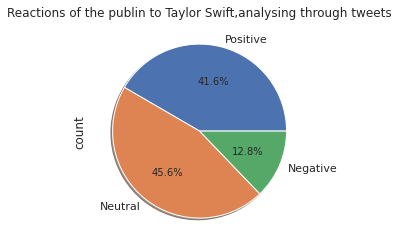

In [39]:
# Plot pie chart for percentage of distributions

my_labels = ["Positive", "Neutral", "Negative"]

plot = x.plot.pie(y='count', title="Reactions of the publin to Taylor Swift,analysing through tweets", legend=False,  \
                   labels = my_labels, autopct='%1.1f%%', explode=(0, 0, 0), \
                   shadow=True, startangle=0)

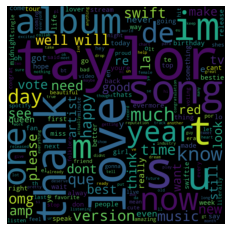

In [40]:
# Plot wordcloud

from wordcloud import WordCloud
#Creating the text variable

text2 = " ".join(title for title in sentiment_vedar_pd.Text)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(collocations = False, background_color = 'black', width = 1000, height =1000).generate(text2)

# Display the generated Word Cloud

plt.imshow(word_cloud2, interpolation='bilinear')

plt.axis("off")

plt.show()

In [41]:
# getting 3 seperate dataframes by taking a subset of the higher number of classes

df_Negative = sentiment_vedar_pd[sentiment_vedar_pd['sentiment'] == 'Negative'][0:1385604]
df_Neutral = sentiment_vedar_pd[sentiment_vedar_pd['sentiment'] == 'Neutral']
df_Positive = sentiment_vedar_pd[sentiment_vedar_pd['sentiment'] == 'Positive']

In [42]:
# applying oversampling to balance the data for distributions

df_Neutral_over = df_Neutral.sample(1385604, replace=True)
df_Positive_over = df_Positive.sample(1385604, replace=True)

# concatinating as a new dataframe with oversampled values to pass into classification model

balance_df = pd.concat([df_Negative, df_Neutral_over, df_Positive_over], axis=0)

<AxesSubplot: xlabel='sentiment', ylabel='count'>

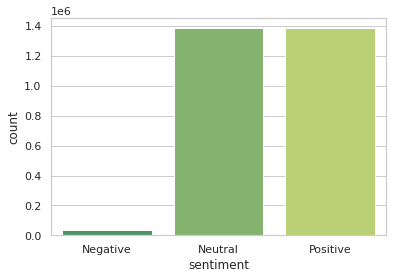

In [43]:
# plot after balancing the data

sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=balance_df, palette='summer')

In [44]:
# writing to csv

balance_df.to_csv("balancedtweets.csv")

In [45]:
# import the processed balanced tweets into mongoDB

# mongoimport --db tweetsdb --collection bigvedartweetcol --type csv --headerline --ignoreBlanks 
# /--file balancedtweets.csv

In [46]:
# Storing preprocessed file into MongoDB
#sentiment_tweets.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("database","tweetsdb").option("collection", "tweetcol3").save()

In [47]:
# reading the processed data from MongoDB for classification model as a sparkdataframe

processed_output = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("spark.mongodb.input.uri","mongodb://127.0.0.1/tweetsdb.bigvedartweetcol").load()

In [48]:
processed_output.show(5)

+--------------------+-------------------+--------------------+---------+--------------+
|                Text|          TweetDate|                 _id|sentiment|sentimentscore|
+--------------------+-------------------+--------------------+---------+--------------+
|yo todava no supe...|2022-04-27 00:58:05|{638ce81654625f0f...| Negative|        -0.296|
|u heard the peopl...|2022-04-27 00:57:30|{638ce81654625f0f...| Negative|       -0.2732|
|and petty means y...|2022-04-27 00:55:30|{638ce81654625f0f...| Negative|       -0.5647|
|you werent mine t...|2022-04-27 00:53:11|{638ce81654625f0f...| Negative|       -0.3699|
|whatttt theeeeee ...|2022-04-27 00:50:02|{638ce81654625f0f...| Negative|       -0.4019|
+--------------------+-------------------+--------------------+---------+--------------+
only showing top 5 rows



In [49]:
#chek schema of the processed dataframe

processed_output.printSchema()

root
 |-- Text: string (nullable = true)
 |-- TweetDate: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- sentimentscore: double (nullable = true)



In [50]:
# Exported the MongoDb Collection to CSV file in shell prompt

# mongoexport --host localhost --db tweetsdb --collection tweetcol3 --type=csv --out processed_tweets.csv --fields TweetDate,Text,sentiment,sentimentscore

In [51]:
#convert tweetdate column datatype as timestamp

df_processed_new1 = processed_output.withColumn("TweetsDate",to_timestamp("TweetDate"))

In [52]:
# drop old column Tweetdate

df_processed_new1 = df_processed_new1.drop("TweetDate")
df_processed_new1.show(2)

+--------------------+--------------------+---------+--------------+-------------------+
|                Text|                 _id|sentiment|sentimentscore|         TweetsDate|
+--------------------+--------------------+---------+--------------+-------------------+
|yo todava no supe...|{638ce81654625f0f...| Negative|        -0.296|2022-04-27 00:58:05|
|u heard the peopl...|{638ce81654625f0f...| Negative|       -0.2732|2022-04-27 00:57:30|
+--------------------+--------------------+---------+--------------+-------------------+
only showing top 2 rows



In [53]:
#Check schema again after converting datatype

df_processed_new1.printSchema()

root
 |-- Text: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- sentimentscore: double (nullable = true)
 |-- TweetsDate: timestamp (nullable = true)



In [54]:
# converting sentiment type into numeric to feed into model like pandas one hot encoding

indexer = StringIndexer(inputCol='sentiment', outputCol='sentiment_numeric').fit(df_processed_new1)
indexed_df = indexer.transform(df_processed_new1)
indexed_df.show(5)

+--------------------+--------------------+---------+--------------+-------------------+-----------------+
|                Text|                 _id|sentiment|sentimentscore|         TweetsDate|sentiment_numeric|
+--------------------+--------------------+---------+--------------+-------------------+-----------------+
|yo todava no supe...|{638ce81654625f0f...| Negative|        -0.296|2022-04-27 00:58:05|              2.0|
|u heard the peopl...|{638ce81654625f0f...| Negative|       -0.2732|2022-04-27 00:57:30|              2.0|
|and petty means y...|{638ce81654625f0f...| Negative|       -0.5647|2022-04-27 00:55:30|              2.0|
|you werent mine t...|{638ce81654625f0f...| Negative|       -0.3699|2022-04-27 00:53:11|              2.0|
|whatttt theeeeee ...|{638ce81654625f0f...| Negative|       -0.4019|2022-04-27 00:50:02|              2.0|
+--------------------+--------------------+---------+--------------+-------------------+-----------------+
only showing top 5 rows



In [55]:
# check schema after transformation

indexed_df.printSchema()

root
 |-- Text: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- sentimentscore: double (nullable = true)
 |-- TweetsDate: timestamp (nullable = true)
 |-- sentiment_numeric: double (nullable = false)



In [56]:
# Renaming sentiment numeric column as label

df2 = indexed_df.select("Text","sentiment_numeric")\
        .withColumnRenamed("sentiment_numeric", "label")

In [57]:
df2.printSchema()

root
 |-- Text: string (nullable = true)
 |-- label: double (nullable = false)



In [58]:
df2.show(5)

+--------------------+-----+
|                Text|label|
+--------------------+-----+
|yo todava no supe...|  2.0|
|u heard the peopl...|  2.0|
|and petty means y...|  2.0|
|you werent mine t...|  2.0|
|whatttt theeeeee ...|  2.0|
+--------------------+-----+
only showing top 5 rows



In [59]:
df3 = df2.na.drop()

In [60]:
# Train test split(70% train, 30% test)

train_df,test_df = df3.randomSplit([0.7, 0.3], 24)

In [61]:
# importing requierd libraries

import nltk
#print(nltk.__version__)
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

lemmatizer = WordNetLemmatizer()  


In [62]:
# create tokens from tweets
tokenizer = Tokenizer(inputCol="Text", outputCol="words1")

# Removing Stopwords from tweets
stopwords_remover = StopWordsRemover(
    inputCol="words1",
    outputCol="words2",
    stopWords=StopWordsRemover.loadDefaultStopWords("english")
)


# create term frequencies for each of the tokens
hashing_tf = HashingTF(
    inputCol="words2",
    outputCol="term_frequency",
)

# create tf-idf for each of the tokens
idf = IDF(
    inputCol="term_frequency",
    outputCol="features",
    minDocFreq=5,
)                    

In [63]:
#train_df.limit(5).toPandas()
train_df.show(5)

+--------------------+-----+
|                Text|label|
+--------------------+-----+
|

i have a broken...|  2.0|
|
by
 ft 

 transc...|  2.0|
|
estos das no pue...|  2.0|
|
i didnt notice t...|  2.0|
|
slowly we lose o...|  2.0|
+--------------------+-----+
only showing top 5 rows



In [64]:
# create basic logistic regression model
lr = LogisticRegression(labelCol="label")

# create entire pipeline
sentiment_analysis_pipeline = Pipeline(
    stages=[tokenizer,stopwords_remover,hashing_tf,idf,lr]
)
   
# Fit sentiment analysis model    
sentiment_analysis_model = sentiment_analysis_pipeline.fit(train_df)

2022-12-04 23:34:57,583 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:36:06,745 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:36:07,653 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:36:10,872 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2022-12-04 23:36:10,873 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
2022-12-04 23:38:03,790 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:38:04,900 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:38:11,664 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:38:12,689 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:38:20,212 WARN scheduler.DAGSchedul

2022-12-04 23:41:42,165 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:41:47,819 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:41:48,668 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:41:53,027 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:41:53,677 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:41:57,755 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:41:58,338 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:42:02,523 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:42:03,099 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:42:06,744 WARN scheduler.DAGScheduler: Broadcasting large task binar

2022-12-04 23:45:21,109 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:25,137 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:25,886 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:29,427 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:30,467 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:34,196 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:34,748 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:38,713 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:39,269 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-04 23:45:42,772 WARN scheduler.DAGScheduler: Broadcasting large task binar

In [65]:
# training Logistic Regression model using train data

trained_df_sa = sentiment_analysis_model.transform(train_df)

In [66]:
#  Logistic Regression model on test data to evaluate the model

test_df_sa = sentiment_analysis_model.transform(test_df)

In [67]:
# train data
trained_df_sa.show(2)

2022-12-04 23:47:31,861 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB


+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                Text|label|              words1|              words2|      term_frequency|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|

  mad woman by ...|  2.0|[, , , , mad, wom...|[, , , , mad, wom...|(262144,[32055,13...|(262144,[32055,13...|[-4.1584729125824...|[5.35769281388738...|       2.0|
|

damn fuck 



 ...|  2.0|[, , damn, fuck, ...|[, , damn, fuck, ...|(262144,[98142,23...|(262144,[98142,23...|[-16.253090227638...|[1.11971817886319...|       2.0|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only

In [68]:
# test data

test_df_sa.show(2)

2022-12-04 23:47:32,915 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB


+--------------------+-----+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|                Text|label|              words1|        words2|      term_frequency|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|


 what s the pl...|  0.0|[, , , , what, s,...|[, , , , plan]|(262144,[232427,2...|(262144,[232427,2...|[4.01205826309779...|[0.99399030849045...|       0.0|
|                 

 |  0.0|                  []|            []|      (262144,[],[])|      (262144,[],[])|[4.61718301088595...|[0.99746587245784...|       0.0|
+--------------------+-----+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 2 rows



In [69]:
#Evaluating Model

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label",metricName = 'accuracy')

accuracy_train = evaluator.evaluate(trained_df_sa)

#Train data accuracy using LR model

print(f"logistic regression model train data accuracy:{accuracy_train * 100:.5f}%")

2022-12-04 23:47:34,611 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB


logistic regression model train data accuracy:99.36739%


In [70]:
# Test data accuracy using LR model

accuracy_test = evaluator.evaluate(test_df_sa)

print(f"logistic regression model test data accuracy:{accuracy_test * 100:.5f}%")

2022-12-04 23:57:48,187 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB


logistic regression model test data accuracy:99.38069%


In [71]:
!pip3 install -U scikit-learn scipy matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# Select columns for classification report
df_lr_report = test_df_sa.select("Text","label","prediction").toPandas()

2022-12-05 00:02:34,408 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.9 MiB


In [73]:
# dataframe for classification report

df_lr_report.head(5)

,Text,label,prediction
0,i hate this song until i hear someone talk shit then its my child to protect\n\nanyways the song that really deserved this treatment,2.0,2.0
1,thats why being a songwriter singer is important you can produce a song anytime you want \nyour mad cause taylor produce and write her own song,2.0,2.0
2,s cast on the song they would sing at karaoke\n\ntaylo smith atw min version \ndaisy shake it off,2.0,2.0
3,that s weird\nthat s suspicious,2.0,2.0
4,st two lines of style\n\nmidnight\nyou come and pick me up no headlights,2.0,0.0


In [74]:
#classification report using Logisitic Regression Model

print(classification_report(df_lr_report.label,df_lr_report.prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    346339
         1.0       0.99      1.00      1.00    415824
         2.0       0.91      0.70      0.79     11157

    accuracy                           0.99    773320
   macro avg       0.97      0.90      0.93    773320
weighted avg       0.99      0.99      0.99    773320



In [75]:

from pyspark.ml.classification import NaiveBayes 
# create basic naive bayes model

nb = NaiveBayes(labelCol="label")

# create entire pipeline
nb_pipeline = Pipeline(
    stages=[tokenizer,stopwords_remover,hashing_tf,idf,nb]
)
# Fit Naive Bayes model
nb_model = nb_pipeline.fit(train_df)

2022-12-05 00:07:59,341 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-05 00:08:54,858 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [76]:
# training Naive Bayes model using train data

trained_df_nb = nb_model.transform(train_df)

In [77]:
# training Naive Bayes model using test data

test_df_nb = nb_model.transform(test_df)

In [78]:
# Check train data using naive bayes

trained_df_nb.show(2)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                Text|label|              words1|              words2|      term_frequency|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|
by
 ft 

 transc...|  2.0|[, by, , ft, , , ...|[, , ft, , , , tr...|(262144,[73712,10...|(262144,[73712,10...|[-1090.8771735734...|[1.65324381412135...|       2.0|
|
estos das no pue...|  2.0|[, estos, das, no...|[, estos, das, pu...|(262144,[32297,43...|(262144,[32297,43...|[-1219.8822343277...|[1.0,8.4730750716...|       0.0|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only

2022-12-05 00:08:59,720 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


In [79]:
# Check test data using naive bayes

test_df_nb.show(2)

2022-12-05 00:09:00,369 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                Text|label|              words1|              words2|      term_frequency|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|
i didnt notice t...|  2.0|[, i, didnt, noti...|[, didnt, notice,...|(262144,[5381,572...|(262144,[5381,572...|[-454.33061500731...|[1.12089442337008...|       1.0|
|
slowly we lose o...|  2.0|[, slowly, we, lo...|[, slowly, lose, ...|(262144,[5765,140...|(262144,[5765,140...|[-1246.3630417288...|[5.48362572391877...|       1.0|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only

In [80]:
#Evaluating Model

evaluator = MulticlassClassificationEvaluator(labelCol="label",metricName = 'accuracy')
nb_accuracy_train = evaluator.evaluate(trained_df_nb)

#Train accuracy of NB model

print(f"NaiveBayes train data accuracy:{nb_accuracy_train * 100:.5f}%")

2022-12-05 00:09:01,141 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


NaiveBayes train data accuracy:83.10058%


In [81]:
#Test accuracy of NB model
nb_accuracy_test = evaluator.evaluate(test_df_nb)

print(f"NaiveBayes test data accuracy:{nb_accuracy_test * 100:.5f}%")


2022-12-05 00:10:00,297 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


NaiveBayes test data accuracy:83.11304%


In [82]:
# Select columns for classification report

df_nb_test_report = test_df_nb.select("Text","label","prediction").toPandas()

2022-12-05 00:10:38,621 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


In [83]:
#classification report using Naive Bayes Model

print(classification_report(df_nb_test_report.label,df_nb_test_report.prediction))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.80    346854
         1.0       0.79      0.96      0.87    415855
         2.0       0.27      0.60      0.38     11171

    accuracy                           0.83    773880
   macro avg       0.68      0.75      0.68    773880
weighted avg       0.86      0.83      0.83    773880



In [84]:
from pyspark.ml.classification import RandomForestClassifier
# create basic RandomForestClassifier model

rf = RandomForestClassifier(labelCol="label")

# create entire pipeline

rf_pipeline = Pipeline(
    stages=[tokenizer,stopwords_remover,hashing_tf,idf,nb]
)

# Fit RandomForestClassifier model
rf_model = rf_pipeline.fit(train_df)

2022-12-05 00:12:07,019 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
2022-12-05 00:13:03,240 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [85]:
# training  RandomForestClassifier model using train data
trained_df_rf = rf_model.transform(train_df)

# training  RandomForestClassifier model using test data
test_df_rf = rf_model.transform(test_df)

In [86]:
# Model evaulation

evaluator = MulticlassClassificationEvaluator(labelCol="label",metricName = 'accuracy')

# train accuracy
rf_accuracy_train = evaluator.evaluate(trained_df_rf)

print(f"RandomForest Model train data accuracy:{rf_accuracy_train * 100:.5f}%")

2022-12-05 00:13:06,805 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


RandomForest Model train data accuracy:83.07424%


In [87]:
# test accuracy
rf_accuracy_test = evaluator.evaluate(test_df_rf)

print(f"Random Forest Model test data accuracy:{rf_accuracy_test * 100:.5f}%")


2022-12-05 00:14:07,195 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


Random Forest Model test data accuracy:83.03585%


In [88]:
# Select columns for classification report
df_rf_test_report = test_df_rf.select("Text","label","prediction").toPandas()

2022-12-05 00:14:44,255 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.1 MiB


In [89]:
#classification report using Naive Bayes Model

print(classification_report(df_rf_test_report.label,df_rf_test_report.prediction))

              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80    346463
         1.0       0.79      0.96      0.87    416162
         2.0       0.27      0.60      0.37     11276

    accuracy                           0.83    773901
   macro avg       0.68      0.75      0.68    773901
weighted avg       0.86      0.83      0.83    773901

